# Proyek Klasifikasi Gambar: Animal -5 Mammal
- **Email:** larassetyadita@gmail.com
- **ID Dicoding:**  larassetyadita

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install kaggle
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 811.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import zipfile, os
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import numpy as np
import cv2
import pandas as pd
from skimage import io, img_as_ubyte
from skimage.transform import AffineTransform, warp, rotate
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import keras
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dwilarassetyadita","key":"d2f7f415843b43155f61143b511b9a8a"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!ls ~/.kaggle

kaggle.json


## Data Preparation

### Data Loading

In [5]:
# menyiapkan dataset yang akan digunakan
!kaggle datasets download -d shiv28/animal-5-mammal -p /kaggle

Dataset URL: https://www.kaggle.com/datasets/shiv28/animal-5-mammal
License(s): GPL-2.0


In [6]:
# mengekstrak file
local_zip = '/kaggle/animal-5-mammal.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/kaggle/animals-image-dataset')
zip_ref.close()

In [7]:
# mengabungkan file yang terpisah
train_directory = '/kaggle/animals-image-dataset/Animal/train'
val_directory = '/kaggle/animals-image-dataset/Animal/val'

# Path folder tujuan gabungan
combined_dir = '/kaggle/combined_dataset'

# Buat folder tujuan jika belum ada
os.makedirs(combined_dir, exist_ok=True)

# Gabungkan file dari train dan val
for split_dir in [train_directory, val_directory]:
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            target_class_dir = os.path.join(combined_dir, class_name)
            os.makedirs(target_class_dir, exist_ok=True)
            for filename in os.listdir(class_path):
                src_file = os.path.join(class_path, filename)
                # Tambahkan prefix agar tidak ada overwrite
                new_filename = f"{os.path.basename(split_dir)}_{filename}"
                dst_file = os.path.join(target_class_dir, new_filename)
                shutil.copy2(src_file, dst_file)

Class Distribution
cat: 3037
LION: 2984
HORSE: 3009
ELEPHANT: 3040
dog: 2927


<ipython-input-8-827489c9dcdf>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette='viridis')


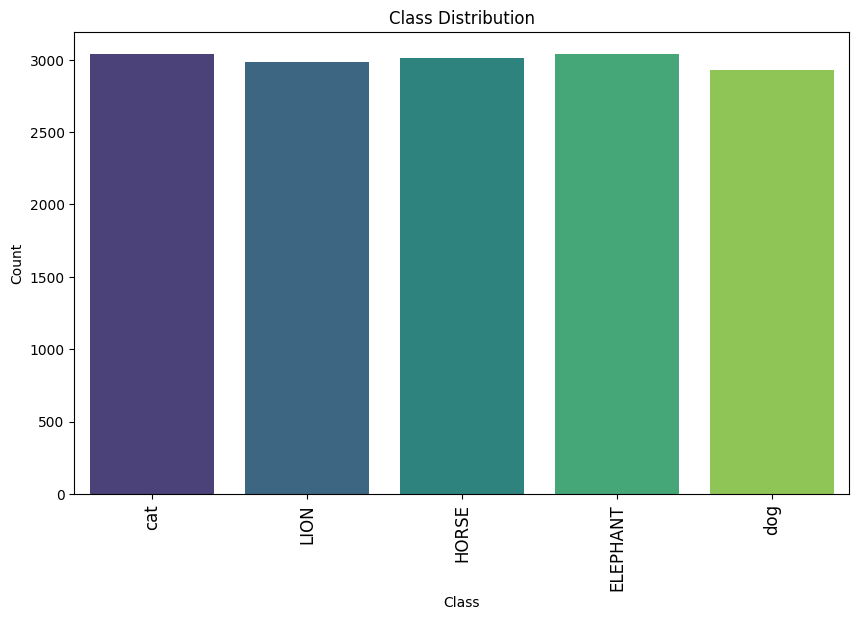

In [8]:
data_dir = '/kaggle/combined_dataset'

class_distribution = {}
for class_name in os.listdir(data_dir):
  class_path = os.path.join(data_dir, class_name)
  if os.path.isdir(class_path):
    num_images = len(os.listdir(class_path))
    class_distribution[class_name] = num_images

print("Class Distribution")

for class_name, count in class_distribution.items():
  print(f"{class_name}: {count}")

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class', fontsize=10)
plt.xticks(rotation=90, fontsize=12)
plt.ylabel('Count', fontsize=10)
plt.show()

- data relatif seimbang untuk semua kelas


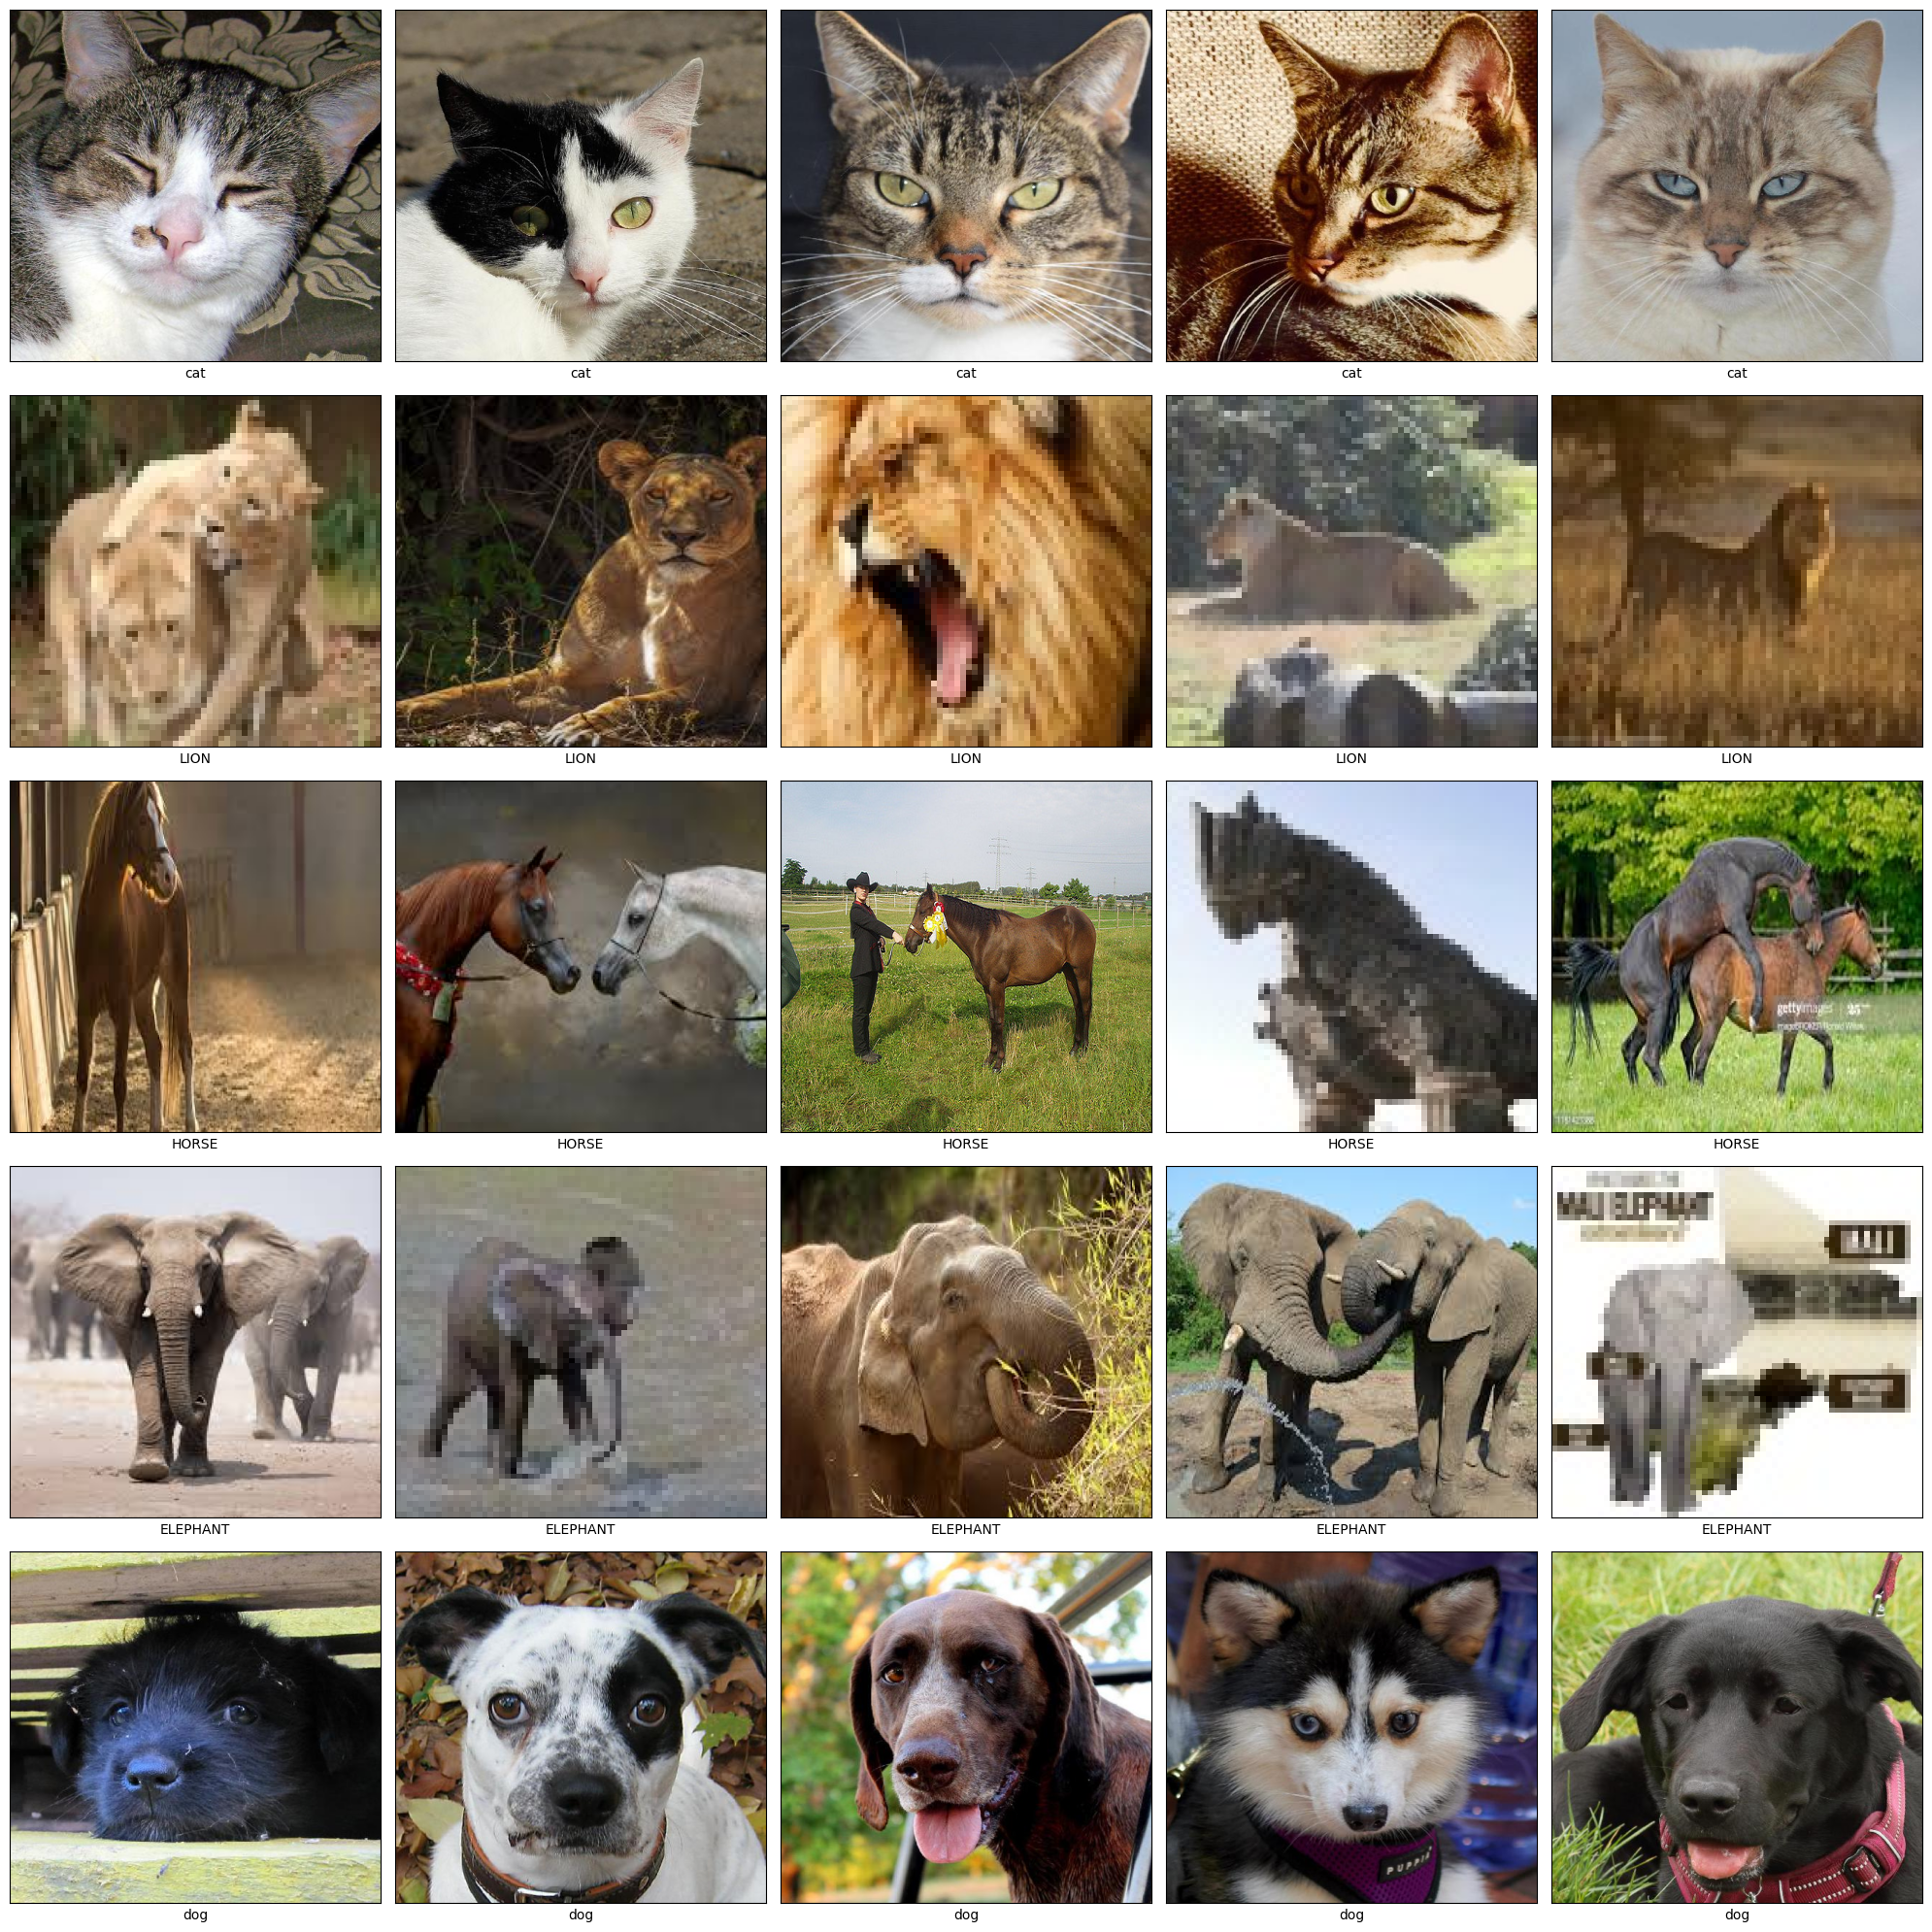

In [9]:
# mengecek data pada setiap kelas

animals_image = {}

for i in os.listdir(data_dir):
  animals_image[i] = os.listdir(os.path.join(data_dir, i))

fig, axs = plt.subplots(len(animals_image.keys()), 5, figsize=(20, 20))

for i, class_name in enumerate(animals_image.keys()):
  images = np.random.choice(animals_image[class_name], 5, replace=False)

  for j, image_name in enumerate(images):
    img_path = os.path.join(data_dir, class_name, image_name)
    img = image.load_img(img_path)
    axs[i, j].imshow(img)
    axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
    axs[i, j].set_aspect('auto')

fig.tight_layout()
plt.show()

### Data Preprocessing

#### Data Augmentation

In [10]:
# function untuk augmentasi data
def to_uint8(img):
    img = np.clip(img * 255, 0, 255).astype(np.uint8)
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def sheared(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    transform = AffineTransform(shear=0.2)
    sheared_img = warp(img, transform, mode="wrap")
    return to_uint8(sheared_img)

def warp_shift(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    transform = AffineTransform(translation=(0, 40))
    warped_img = warp(img, transform, mode="wrap")
    return to_uint8(warped_img)

def blur_image(img):
    img = cv2.resize(img, (224, 224))
    blur_img = cv2.GaussianBlur(img, (9, 9), 0)
    return blur_img

def add_brightness(img):
    img = cv2.resize(img, (224, 224))
    bright_img = cv2.convertScaleAbs(img, alpha=1.5, beta=30)
    return bright_img

def clockwise_rotation(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    angle = random.randint(5, 45)
    rotated = rotate(img, -angle, mode='wrap')
    return to_uint8(rotated)

def anticlockwise_rotation(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    angle = random.randint(5, 45)
    rotated = rotate(img, angle, mode='wrap')
    return to_uint8(rotated)

In [11]:
transformation = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'sheared': sheared
}

augmented_path = '/kaggle/augmented_dataset'
target_total_per_class = 3500  # Jumlah target per kelas

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)

    if not os.path.isdir(class_path):
        continue

    class_augmented_path = os.path.join(augmented_path, class_name)
    os.makedirs(class_augmented_path, exist_ok=True)

    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith('.jpg') or img.endswith('.png') or img.endswith('.jpeg')]

    for img in images:
        shutil.copy(img, os.path.join(class_augmented_path, os.path.basename(img)))

    current_count = len(images)
    num_to_generate = target_total_per_class - current_count
    print(f"{class_name} | Original: {current_count} | Augmenting: {num_to_generate}")

    if num_to_generate <= 0:
        print(f"Class {class_name} already has {current_count} images. Skipping augmentation.")
        continue

    # Proses augmentasi gambar
    i = 1
    while i <= num_to_generate:
        image_path = random.choice(images)
        img_cv = cv2.imread(image_path)

        # transformasi secara acak
        transformation_name, transformation_function = random.choice(list(transformation.items()))
        augmented_image = transformation_function(img_cv)

        # Simpan gambar hasil augmentasi
        filename = f"{class_name}_{transformation_name}_{i}.jpg"
        save_path = os.path.join(class_augmented_path, filename)
        cv2.imwrite(save_path, augmented_image)
        i += 1

cat | Original: 3037 | Augmenting: 463
LION | Original: 2983 | Augmenting: 517
HORSE | Original: 3009 | Augmenting: 491
ELEPHANT | Original: 3040 | Augmenting: 460
dog | Original: 2927 | Augmenting: 573


Class Distribution
cat: 3500
LION: 3500
HORSE: 3500
ELEPHANT: 3500
dog: 3500


<ipython-input-12-23bafcf45767>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette='viridis')


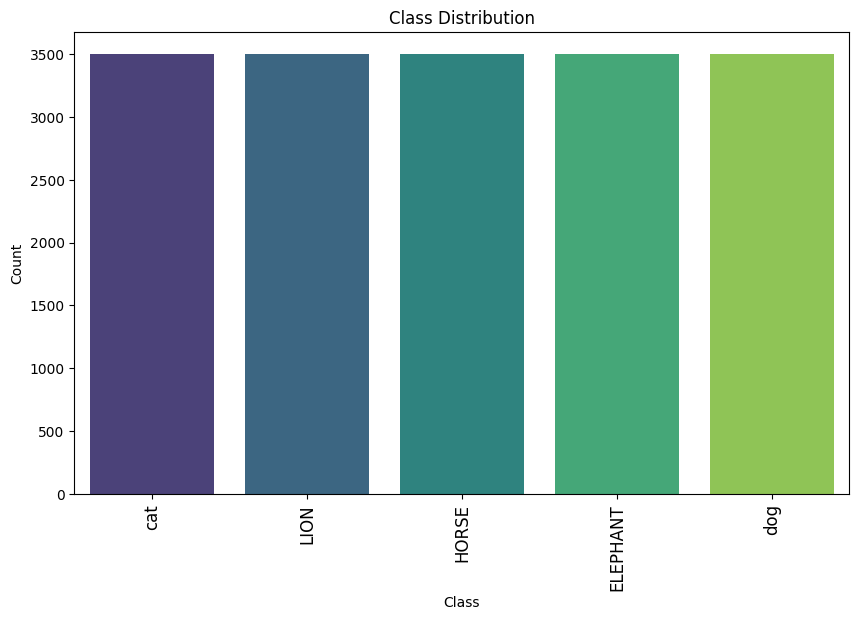

In [12]:

class_distribution = {}
for class_name in os.listdir(augmented_path):
  class_path = os.path.join(augmented_path, class_name)
  if os.path.isdir(class_path):
    num_images = len(os.listdir(class_path))
    class_distribution[class_name] = num_images

print("Class Distribution")

for class_name, count in class_distribution.items():
  print(f"{class_name}: {count}")

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class', fontsize=10)
plt.xticks(rotation=90, fontsize=12)
plt.ylabel('Count', fontsize=10)
plt.show()

#### Split Dataset

In [13]:
def split_balanced_dataset(input_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    for cls in os.listdir(input_dir):
        cls_dir = os.path.join(input_dir, cls)
        if not os.path.isdir(cls_dir):
            continue

        images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir)
                  if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

        random.shuffle(images)

        total_images = len(images)
        train_len = int(train_ratio * total_images)
        val_len = int(val_ratio * total_images)
        test_len = total_images - train_len - val_len

        split_data = {
            'train': images[:train_len],
            'val': images[train_len:train_len + val_len],
            'test': images[train_len + val_len:]
        }

        for split, files in split_data.items():
            split_cls_dir = os.path.join(output_dir, split, cls)
            os.makedirs(split_cls_dir, exist_ok=True)
            for file_path in files:
                shutil.copy(file_path, os.path.join(split_cls_dir, os.path.basename(file_path)))

        print(f"Kelas '{cls}': Total={total_images} | Train={train_len}, Val={val_len}, Test={test_len}")

    print("\nDataset berhasil di-split dengan rasio 80:10:10.")

# Contoh pemanggilan:
split_balanced_dataset('/kaggle/augmented_dataset', '/kaggle/splited_dataset')

Kelas 'cat': Total=3500 | Train=2800, Val=350, Test=350
Kelas 'LION': Total=3500 | Train=2800, Val=350, Test=350
Kelas 'HORSE': Total=3500 | Train=2800, Val=350, Test=350
Kelas 'ELEPHANT': Total=3500 | Train=2800, Val=350, Test=350
Kelas 'dog': Total=3500 | Train=2800, Val=350, Test=350

Dataset berhasil di-split dengan rasio 80:10:10.


In [14]:
base_dir = '/kaggle/splited_dataset'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

In [15]:
data_df = []

for dataset_type in ['train', 'test', 'val']:
  dataset_path = os.path.join(base_dir, dataset_type)

  if not os.path.isdir(dataset_path):
    continue

  for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    for image_name in os.listdir(class_path):
      if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(class_path, image_name)
        data_df.append({
            'path' : image_path,
            'label' : class_name,
            'set' : dataset_type
        })

df_animals = pd.DataFrame(data_df)
df_animals.head()



path label    set
0  /kaggle/splited_dataset/train/cat/train_pixaba...   cat  train
1  /kaggle/splited_dataset/train/cat/val_pixabay_...   cat  train
2  /kaggle/splited_dataset/train/cat/train_pixaba...   cat  train
3  /kaggle/splited_dataset/train/cat/val_pixabay_...   cat  train
4  /kaggle/splited_dataset/train/cat/train_pixaba...   cat  train

In [16]:
df_animals['set'].value_counts()
df_animals['label'].value_counts()

label
cat         3500
LION        3500
HORSE       3500
ELEPHANT    3500
dog         3500
Name: count, dtype: int64

In [17]:
kelas_train = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
print('kelas train : ', kelas_train)

kelas_test = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
print('kelas test : ', kelas_test)

kelas_val = [d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d))]
print('kelas val : ', kelas_val)

kelas train :  ['cat', 'LION', 'HORSE', 'ELEPHANT', 'dog']
kelas test :  ['cat', 'LION', 'HORSE', 'ELEPHANT', 'dog']
kelas val :  ['cat', 'LION', 'HORSE', 'ELEPHANT', 'dog']


Class Distribution
cat: 2800
LION: 2800
HORSE: 2800
ELEPHANT: 2800
dog: 2800


<ipython-input-18-57c2516e463c>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette='viridis')


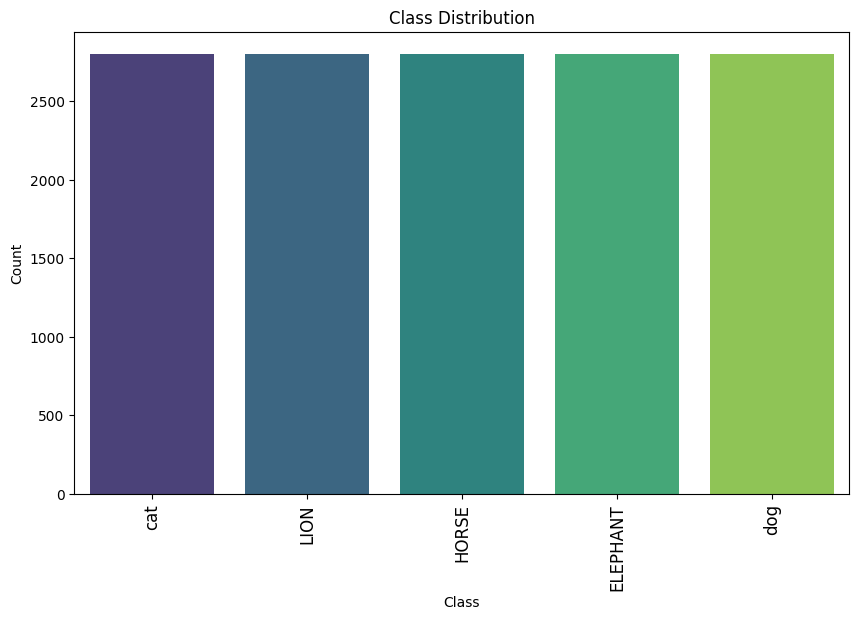

In [18]:
# melihat persebaran data train
class_distribution = {}
for class_name in os.listdir(train_dir):
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    num_images = len(os.listdir(class_path))
    class_distribution[class_name] = num_images

print("Class Distribution")

for class_name, count in class_distribution.items():
  print(f"{class_name}: {count}")

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class', fontsize=10)
plt.xticks(rotation=90, fontsize=12)
plt.ylabel('Count', fontsize=10)
plt.show()

Class Distribution
cat: 350
LION: 350
HORSE: 350
ELEPHANT: 350
dog: 350


<ipython-input-19-0bb505fa2e44>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette='viridis')


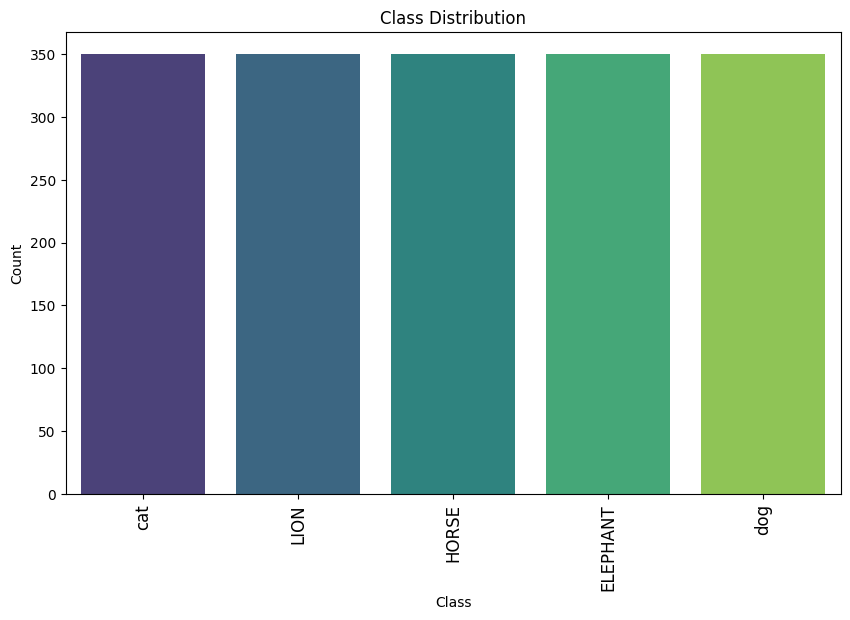

In [19]:
# melihat persebaran data test
class_distribution = {}
for class_name in os.listdir(test_dir):
  class_path = os.path.join(test_dir, class_name)
  if os.path.isdir(class_path):
    num_images = len(os.listdir(class_path))
    class_distribution[class_name] = num_images

print("Class Distribution")

for class_name, count in class_distribution.items():
  print(f"{class_name}: {count}")

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class', fontsize=10)
plt.xticks(rotation=90, fontsize=12)
plt.ylabel('Count', fontsize=10)
plt.show()

Class Distribution
cat: 350
LION: 350
HORSE: 350
ELEPHANT: 350
dog: 350


<ipython-input-20-d5c74431a0a7>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette='viridis')


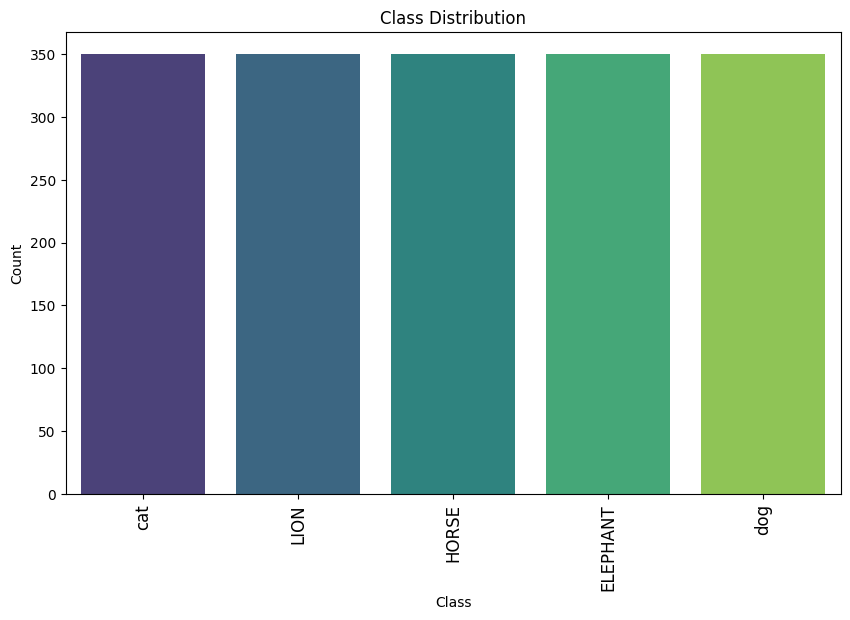

In [20]:
# melihat persebaran data validation
class_distribution = {}
for class_name in os.listdir(val_dir):
  class_path = os.path.join(val_dir, class_name)
  if os.path.isdir(class_path):
    num_images = len(os.listdir(class_path))
    class_distribution[class_name] = num_images

print("Class Distribution")

for class_name, count in class_distribution.items():
  print(f"{class_name}: {count}")

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class', fontsize=10)
plt.xticks(rotation=90, fontsize=12)
plt.ylabel('Count', fontsize=10)
plt.show()

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

# Hanya rescale untuk Data Validasi (Tanpa Augmentasi)
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Menggunakan Flow From Directory untuk Data Pelatihan
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

# Menggunakan Flow From Directory untuk Data Validasi
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 14000 images belonging to 5 classes.
Found 1750 images belonging to 5 classes.
Found 1750 images belonging to 5 classes.


## Modelling

In [22]:
model = Sequential()

# layer pertama
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# layer kedua
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


#layer ketida
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#layer keempat
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#layer kelima
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(5, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 9, 9, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,646,789 (6.28 MB)

 Trainable params: 1,644,805 (6.27 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [24]:
# menyesauaikan bobot
labels = df_animals['label']

class_names = np.unique(labels)

class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=class_names,
    y=labels
)

class_weights = dict(zip(range(len(class_names)), class_weights_values))

# Cek hasilnya
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0)}


In [25]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.optimizers.Adam(),
    metrics = ['accuracy']
)

In [26]:
# EarlyStopping callback
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', # val accuracy karena saat ini memprioritaskan val accuraacy yang tinggi berdasarkan ketentuan submission
    min_delta=0.001,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# ReduceLROnPlateau callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


# TensorBoard callback
tb = tf.keras.callbacks.TensorBoard(log_dir='tensorboard_logs')


In [27]:
# training model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=2,
    callbacks=[es, lr_scheduler, tb, checkpoint],
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to best_model.h5


219/219 - 128s - 584ms/step - accuracy: 0.4998 - loss: 1.2540 - val_accuracy: 0.2000 - val_loss: 4.1973 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_accuracy improved from 0.20000 to 0.38743, saving model to best_model.h5


219/219 - 121s - 555ms/step - accuracy: 0.7116 - loss: 0.7591 - val_accuracy: 0.3874 - val_loss: 1.7373 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_accuracy improved from 0.38743 to 0.63086, saving model to best_model.h5


219/219 - 106s - 485ms/step - accuracy: 0.8007 - loss: 0.5328 - val_accuracy: 0.6309 - val_loss: 1.0863 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_accuracy improved from 0.63086 to 0.76914, saving model to best_model.h5


219/219 - 139s - 632ms/step - accuracy: 0.8394 - loss: 0.4323 - val_accuracy: 0.7691 - val_loss: 0.6055 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.76914
219/219 - 101s - 461ms/step - accuracy: 0.8636 - loss: 0.3617 - val_accuracy: 0.7606 - val_loss: 0.5730 - learning_rate: 1.0000e-03
Epoch 6/50

Epoch 6: val_accuracy improved from 0.76914 to 0.86343, saving model to best_model.h5


219/219 - 103s - 471ms/step - accuracy: 0.8831 - loss: 0.3207 - val_accuracy: 0.8634 - val_loss: 0.3476 - learning_rate: 1.0000e-03
Epoch 7/50

Epoch 7: val_accuracy did not improve from 0.86343
219/219 - 101s - 462ms/step - accuracy: 0.8995 - loss: 0.2764 - val_accuracy: 0.7480 - val_loss: 0.7332 - learning_rate: 1.0000e-03
Epoch 8/50

Epoch 8: val_accuracy did not improve from 0.86343
219/219 - 144s - 656ms/step - accuracy: 0.9071 - loss: 0.2581 - val_accuracy: 0.8411 - val_loss: 0.4155 - learning_rate: 1.0000e-03
Epoch 9/50

Epoch 9: val_accuracy improved from 0.86343 to 0.87429, saving model to best_model.h5


219/219 - 143s - 654ms/step - accuracy: 0.9152 - loss: 0.2315 - val_accuracy: 0.8743 - val_loss: 0.3434 - learning_rate: 1.0000e-03
Epoch 10/50

Epoch 10: val_accuracy improved from 0.87429 to 0.88400, saving model to best_model.h5


219/219 - 102s - 467ms/step - accuracy: 0.9240 - loss: 0.2189 - val_accuracy: 0.8840 - val_loss: 0.3143 - learning_rate: 1.0000e-03
Epoch 11/50

Epoch 11: val_accuracy did not improve from 0.88400
219/219 - 142s - 647ms/step - accuracy: 0.9255 - loss: 0.2074 - val_accuracy: 0.8017 - val_loss: 0.6605 - learning_rate: 1.0000e-03
Epoch 12/50

Epoch 12: val_accuracy improved from 0.88400 to 0.89943, saving model to best_model.h5


219/219 - 102s - 466ms/step - accuracy: 0.9334 - loss: 0.1848 - val_accuracy: 0.8994 - val_loss: 0.2866 - learning_rate: 1.0000e-03
Epoch 13/50

Epoch 13: val_accuracy did not improve from 0.89943
219/219 - 102s - 468ms/step - accuracy: 0.9379 - loss: 0.1763 - val_accuracy: 0.8554 - val_loss: 0.4349 - learning_rate: 1.0000e-03
Epoch 14/50

Epoch 14: val_accuracy did not improve from 0.89943
219/219 - 145s - 660ms/step - accuracy: 0.9401 - loss: 0.1674 - val_accuracy: 0.8451 - val_loss: 0.3845 - learning_rate: 1.0000e-03
Epoch 15/50

Epoch 15: val_accuracy did not improve from 0.89943
219/219 - 138s - 632ms/step - accuracy: 0.9439 - loss: 0.1519 - val_accuracy: 0.8731 - val_loss: 0.3620 - learning_rate: 1.0000e-03
Epoch 16/50

Epoch 16: val_accuracy did not improve from 0.89943
219/219 - 144s - 658ms/step - accuracy: 0.9466 - loss: 0.1522 - val_accuracy: 0.8509 - val_loss: 0.3927 - learning_rate: 1.0000e-03
Epoch 17/50

Epoch 17: val_accuracy improved from 0.89943 to 0.90971, saving mod

219/219 - 102s - 468ms/step - accuracy: 0.9553 - loss: 0.1317 - val_accuracy: 0.9097 - val_loss: 0.2667 - learning_rate: 1.0000e-03
Epoch 18/50

Epoch 18: val_accuracy did not improve from 0.90971
219/219 - 102s - 467ms/step - accuracy: 0.9551 - loss: 0.1223 - val_accuracy: 0.8863 - val_loss: 0.3265 - learning_rate: 1.0000e-03
Epoch 19/50

Epoch 19: val_accuracy did not improve from 0.90971
219/219 - 103s - 471ms/step - accuracy: 0.9581 - loss: 0.1181 - val_accuracy: 0.8777 - val_loss: 0.5037 - learning_rate: 1.0000e-03
Epoch 20/50

Epoch 20: val_accuracy did not improve from 0.90971
219/219 - 142s - 649ms/step - accuracy: 0.9582 - loss: 0.1133 - val_accuracy: 0.8966 - val_loss: 0.2987 - learning_rate: 1.0000e-03
Epoch 21/50

Epoch 21: val_accuracy did not improve from 0.90971
219/219 - 101s - 463ms/step - accuracy: 0.9611 - loss: 0.1097 - val_accuracy: 0.8943 - val_loss: 0.3537 - learning_rate: 1.0000e-03
Epoch 22/50

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00050000002

219/219 - 103s - 469ms/step - accuracy: 0.9736 - loss: 0.0746 - val_accuracy: 0.9417 - val_loss: 0.1803 - learning_rate: 5.0000e-04
Epoch 24/50

Epoch 24: val_accuracy did not improve from 0.94171
219/219 - 102s - 464ms/step - accuracy: 0.9834 - loss: 0.0509 - val_accuracy: 0.9263 - val_loss: 0.2294 - learning_rate: 5.0000e-04
Epoch 25/50

Epoch 25: val_accuracy did not improve from 0.94171
219/219 - 142s - 649ms/step - accuracy: 0.9839 - loss: 0.0489 - val_accuracy: 0.9349 - val_loss: 0.2161 - learning_rate: 5.0000e-04
Epoch 26/50

Epoch 26: val_accuracy did not improve from 0.94171
219/219 - 104s - 474ms/step - accuracy: 0.9833 - loss: 0.0533 - val_accuracy: 0.9200 - val_loss: 0.3122 - learning_rate: 5.0000e-04
Epoch 27/50

Epoch 27: val_accuracy did not improve from 0.94171
219/219 - 141s - 644ms/step - accuracy: 0.9849 - loss: 0.0471 - val_accuracy: 0.9406 - val_loss: 0.2003 - learning_rate: 5.0000e-04
Epoch 28/50

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.00025000001

219/219 - 103s - 470ms/step - accuracy: 0.9916 - loss: 0.0235 - val_accuracy: 0.9446 - val_loss: 0.2122 - learning_rate: 2.5000e-04
Epoch 33/50

Epoch 33: val_accuracy did not improve from 0.94457
219/219 - 145s - 663ms/step - accuracy: 0.9926 - loss: 0.0217 - val_accuracy: 0.9354 - val_loss: 0.2593 - learning_rate: 2.5000e-04
Epoch 34/50

Epoch 34: val_accuracy did not improve from 0.94457
219/219 - 102s - 465ms/step - accuracy: 0.9929 - loss: 0.0210 - val_accuracy: 0.9434 - val_loss: 0.2239 - learning_rate: 2.5000e-04
Epoch 35/50

Epoch 35: val_accuracy did not improve from 0.94457
219/219 - 144s - 657ms/step - accuracy: 0.9938 - loss: 0.0199 - val_accuracy: 0.9371 - val_loss: 0.2343 - learning_rate: 2.5000e-04
Epoch 36/50

Epoch 36: val_accuracy did not improve from 0.94457
219/219 - 142s - 648ms/step - accuracy: 0.9944 - loss: 0.0189 - val_accuracy: 0.9406 - val_loss: 0.2369 - learning_rate: 2.5000e-04
Epoch 37/50

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.00012500000

219/219 - 147s - 672ms/step - accuracy: 0.9949 - loss: 0.0154 - val_accuracy: 0.9457 - val_loss: 0.2172 - learning_rate: 1.2500e-04
Epoch 39/50

Epoch 39: val_accuracy did not improve from 0.94571
219/219 - 138s - 631ms/step - accuracy: 0.9956 - loss: 0.0120 - val_accuracy: 0.9434 - val_loss: 0.2141 - learning_rate: 1.2500e-04
Epoch 40/50

Epoch 40: val_accuracy did not improve from 0.94571
219/219 - 102s - 467ms/step - accuracy: 0.9969 - loss: 0.0099 - val_accuracy: 0.9457 - val_loss: 0.2206 - learning_rate: 1.2500e-04
Epoch 41/50

Epoch 41: val_accuracy improved from 0.94571 to 0.94743, saving model to best_model.h5


219/219 - 140s - 638ms/step - accuracy: 0.9970 - loss: 0.0091 - val_accuracy: 0.9474 - val_loss: 0.2438 - learning_rate: 1.2500e-04
Epoch 42/50

Epoch 42: val_accuracy did not improve from 0.94743
219/219 - 142s - 647ms/step - accuracy: 0.9974 - loss: 0.0089 - val_accuracy: 0.9451 - val_loss: 0.2471 - learning_rate: 1.2500e-04
Epoch 43/50

Epoch 43: val_accuracy improved from 0.94743 to 0.94971, saving model to best_model.h5


219/219 - 101s - 463ms/step - accuracy: 0.9974 - loss: 0.0076 - val_accuracy: 0.9497 - val_loss: 0.2373 - learning_rate: 1.2500e-04
Epoch 44/50

Epoch 44: val_accuracy improved from 0.94971 to 0.95200, saving model to best_model.h5


219/219 - 141s - 644ms/step - accuracy: 0.9969 - loss: 0.0094 - val_accuracy: 0.9520 - val_loss: 0.2349 - learning_rate: 1.2500e-04
Epoch 45/50

Epoch 45: val_accuracy did not improve from 0.95200
219/219 - 141s - 643ms/step - accuracy: 0.9964 - loss: 0.0096 - val_accuracy: 0.9474 - val_loss: 0.2599 - learning_rate: 1.2500e-04
Epoch 46/50

Epoch 46: val_accuracy did not improve from 0.95200
219/219 - 99s - 453ms/step - accuracy: 0.9976 - loss: 0.0077 - val_accuracy: 0.9480 - val_loss: 0.2828 - learning_rate: 1.2500e-04
Epoch 47/50

Epoch 47: val_accuracy did not improve from 0.95200
219/219 - 102s - 468ms/step - accuracy: 0.9973 - loss: 0.0081 - val_accuracy: 0.9434 - val_loss: 0.2751 - learning_rate: 1.2500e-04
Epoch 48/50

Epoch 48: val_accuracy did not improve from 0.95200
219/219 - 102s - 464ms/step - accuracy: 0.9964 - loss: 0.0095 - val_accuracy: 0.9474 - val_loss: 0.2825 - learning_rate: 1.2500e-04
Epoch 49/50

Epoch 49: ReduceLROnPlateau reducing learning rate to 6.250000296859

219/219 - 102s - 465ms/step - accuracy: 0.9971 - loss: 0.0089 - val_accuracy: 0.9566 - val_loss: 0.2322 - learning_rate: 6.2500e-05
Restoring model weights from the end of the best epoch: 50.


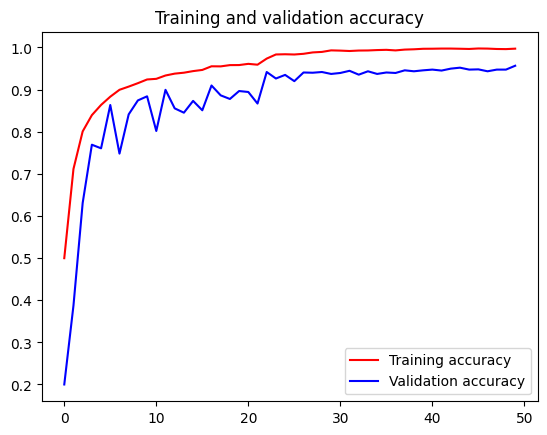

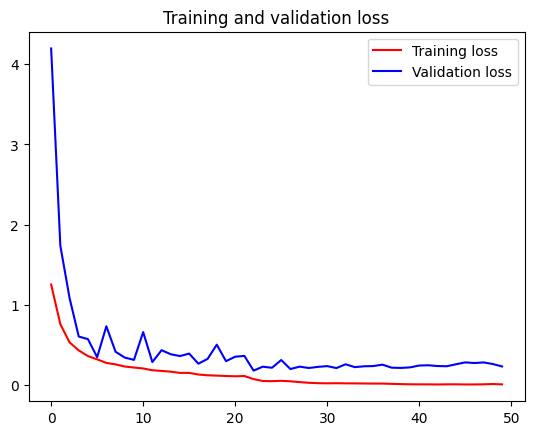

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluasi dan Visualisasi

In [29]:
# Evaluasi model menggunakan data pengujian
evaluation = model.evaluate(
    test_generator,
    steps=test_generator.samples
)

# Menampilkan hasil evaluasi
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9568 - loss: 0.2301    
Loss: 0.22866088151931763
Accuracy: 0.9571428298950195


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step


<Figure size 800x600 with 0 Axes>

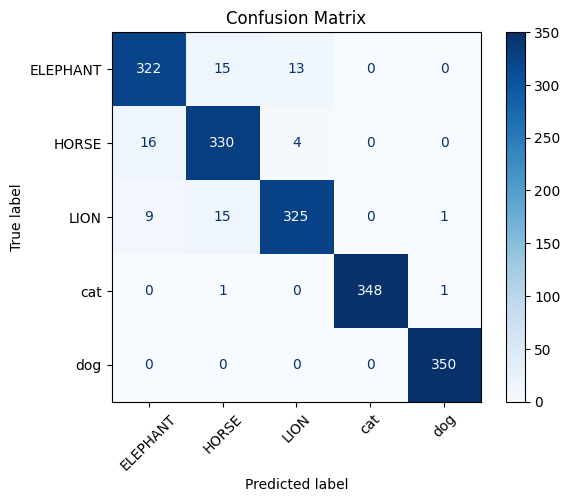

Classification Report:
              precision    recall  f1-score   support

    ELEPHANT       0.93      0.92      0.92       350
       HORSE       0.91      0.94      0.93       350
        LION       0.95      0.93      0.94       350
         cat       1.00      0.99      1.00       350
         dog       0.99      1.00      1.00       350

    accuracy                           0.96      1750
   macro avg       0.96      0.96      0.96      1750
weighted avg       0.96      0.96      0.96      1750



In [30]:
# Ambil prediksi dan label asli
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Daftar nama kelas
class_names = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

## Konversi Model

In [31]:
# Konversi model H5 ke TensorFlow.js
!tensorflowjs_converter \
    --input_format=keras \
    /content/best_model.h5 \
    /content/modeltfjs

#  unduh folder hasilnya
shutil.make_archive('/content/modeltfjs', 'zip', '/content', 'modeltfjs')
files.download('/content/modeltfjs.zip')

2025-04-24 15:15:38.342056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745507738.361700   27851 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745507738.367631   27851 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
keras_model_path = '/content/best_model.h5'  # Ganti dengan path yang sesuai

keras_model = tf.keras.models.load_model(keras_model_path)

# Konversi model Keras ke model TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

# Simpan model TFLite ke dalam file .tflite
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)


class_names = sorted(os.listdir(train_dir))

# Simpan nama kelas ke dalam file label.txt
with open('/content/label.txt', 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

shutil.make_archive('/content/model', 'zip', '/content', 'model.tflite', 'label.txt')
files.download('/content/model.zip')

Saved artifact at '/tmp/tmp7l3r7z76'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  135108455535952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135108455536912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135106796137424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135106796139920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135108455534416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135106796138384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135106796140304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135106796141264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135106796137808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135106796141840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135106796138960

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
# Menyimpan model ke SavedModel format
save_path = '/content/saved_model/'
tf.saved_model.save(model, save_path)

# mendownload model dalam format zip karena kode ini dijalankan di google colab
shutil.make_archive('/content/saved_model', 'zip', save_path)
files.download('/content/saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

Saving gajah.webp to gajah.webp
Prediksi per label:
ELEPHANT  : 0.9717
HORSE     : 0.0183
LION      : 0.0088
cat       : 0.0001
dog       : 0.0010


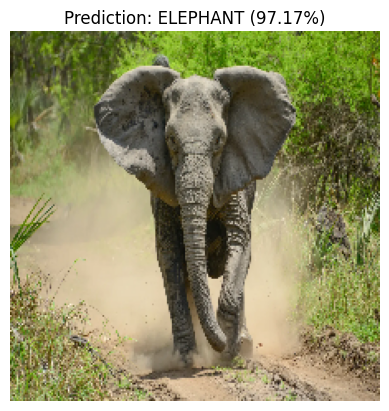

In [35]:
# Upload file gambar
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Load model
saved_model_path = '/content/saved_model'
model = tf.saved_model.load(saved_model_path)
infer = model.signatures["serving_default"]

# Daftar label
labels = ['ELEPHANT', 'HORSE', 'LION', 'cat', 'dog']

# Preprocessing gambar
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Inference
predictions = infer(tf.convert_to_tensor(img_array, dtype=tf.float32))
probs = list(predictions.values())[0].numpy()[0]

# Tampilkan hasil prediksi
print("Prediksi per label:")
for label, prob in zip(labels, probs):
    print(f"{label:<10}: {prob:.4f}")

# Ambil prediksi tertinggi
max_index = np.argmax(probs)
predicted_label = labels[max_index]
confidence = probs[max_index]

# Tampilkan gambar dan prediksi
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {predicted_label} ({confidence:.2%})")
plt.show()

In [ ]:
import shutil
import os

# Ganti ini dengan path folder yang ingin kamu hapus
folder_path = '/kaggle/splited_dataset'

# Cek apakah folder tersebut ada
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Folder '{folder_path}' berhasil dihapus.")
else:
    print(f"Folder '{folder_path}' tidak ditemukan.")

Folder '/kaggle/splited_dataset' berhasil dihapus.
